In [3]:
"""
File name: rbm.ipynb
Original file location: https://github.com/GabrielBianconi/pytorch-rbm
Edited by: Anton Karazeev <anton.karazeev@gmail.com>
"""

import torch


class RBM():

    def __init__(self, num_visible, num_hidden, k, learning_rate=1e-3, momentum_coefficient=0.5, weight_decay=1e-4, use_cuda=True):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.learning_rate = learning_rate
        self.momentum_coefficient = momentum_coefficient
        self.weight_decay = weight_decay
        self.use_cuda = use_cuda

        self.weights = torch.randn(num_visible, num_hidden) * 0.1
        self.visible_bias = torch.ones(num_visible) * 0.5
        self.hidden_bias = torch.zeros(num_hidden)

        self.weights_momentum = torch.zeros(num_visible, num_hidden)
        self.visible_bias_momentum = torch.zeros(num_visible)
        self.hidden_bias_momentum = torch.zeros(num_hidden)

        if self.use_cuda:
            self.weights = self.weights.cuda()
            self.visible_bias = self.visible_bias.cuda()
            self.hidden_bias = self.hidden_bias.cuda()

            self.weights_momentum = self.weights_momentum.cuda()
            self.visible_bias_momentum = self.visible_bias_momentum.cuda()
            self.hidden_bias_momentum = self.hidden_bias_momentum.cuda()

    def sample_hidden(self, visible_probabilities):
        hidden_activations = torch.matmul(visible_probabilities, self.weights) + self.hidden_bias
        hidden_probabilities = self._sigmoid(hidden_activations)
        return hidden_probabilities

    def sample_visible(self, hidden_probabilities):
        visible_activations = torch.matmul(hidden_probabilities, self.weights.t()) + self.visible_bias
        visible_probabilities = self._sigmoid(visible_activations)
        return visible_probabilities

    def contrastive_divergence(self, input_data):
        # Positive phase
        positive_hidden_probabilities = self.sample_hidden(input_data)
        positive_hidden_activations = (positive_hidden_probabilities >= self._random_probabilities(self.num_hidden)).float()
        positive_associations = torch.matmul(input_data.t(), positive_hidden_activations)

        # Negative phase
        hidden_activations = positive_hidden_activations

        for step in range(self.k):
            visible_probabilities = self.sample_visible(hidden_activations)
            hidden_probabilities = self.sample_hidden(visible_probabilities)
            hidden_activations = (hidden_probabilities >= self._random_probabilities(self.num_hidden)).float()

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        negative_associations = torch.matmul(negative_visible_probabilities.t(), negative_hidden_probabilities)

        # Update parameters
        self.weights_momentum *= self.momentum_coefficient
        self.weights_momentum += (positive_associations - negative_associations)

        self.visible_bias_momentum *= self.momentum_coefficient
        self.visible_bias_momentum += torch.sum(input_data - negative_visible_probabilities, dim=0)

        self.hidden_bias_momentum *= self.momentum_coefficient
        self.hidden_bias_momentum += torch.sum(positive_hidden_probabilities - negative_hidden_probabilities, dim=0)

        batch_size = input_data.size(0)

        self.weights += self.weights_momentum * self.learning_rate / batch_size
        self.visible_bias += self.visible_bias_momentum * self.learning_rate / batch_size
        self.hidden_bias += self.hidden_bias_momentum * self.learning_rate / batch_size

        self.weights -= self.weights * self.weight_decay  # L2 weight decay

        # Compute reconstruction error
        error = torch.sum((input_data - negative_visible_probabilities)**2)

        return error

    def _sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def _random_probabilities(self, num):
        random_probabilities = torch.rand(num)

        if self.use_cuda:
            random_probabilities = random_probabilities.cuda()

        return random_probabilities

In [6]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms


########## CONFIGURATION ##########
BATCH_SIZE = 64
VISIBLE_UNITS = 784  # 28 x 28 images
HIDDEN_UNITS = 128
CD_K = 2
EPOCHS = 10

DATA_FOLDER = 'data/mnist'

CUDA = torch.cuda.is_available()
CUDA_DEVICE = 0

if CUDA:
    torch.cuda.set_device(CUDA_DEVICE)

In [7]:
########## LOADING DATASET ##########
print('Loading dataset...')

train_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = torchvision.datasets.MNIST(root=DATA_FOLDER, train=False, transform=torchvision.transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Loading dataset...
Processing...
Done!


In [8]:
########## TRAINING RBM ##########
print('Training RBM...')

rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K, use_cuda=CUDA)

for epoch in range(EPOCHS):
    epoch_error = 0.0

    for batch, _ in train_loader:
        batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data

        if CUDA:
            batch = batch.cuda()

        batch_error = rbm.contrastive_divergence(batch)

        epoch_error += batch_error

    print('Epoch Error (epoch=%d): %.4f' % (epoch, epoch_error))

Training RBM...
Epoch Error (epoch=0): 5713282.1035
Epoch Error (epoch=1): 3079574.5609
Epoch Error (epoch=2): 2442374.7704
Epoch Error (epoch=3): 2216324.7767
Epoch Error (epoch=4): 2097251.7354
Epoch Error (epoch=5): 2015374.6502
Epoch Error (epoch=6): 1959431.8966
Epoch Error (epoch=7): 1916946.7262
Epoch Error (epoch=8): 1884462.3800
Epoch Error (epoch=9): 1851922.0698


In [9]:
########## EXTRACT FEATURES ##########
print('Extracting features...')

train_features = np.zeros((len(train_dataset), HIDDEN_UNITS))
train_labels = np.zeros(len(train_dataset))
test_features = np.zeros((len(test_dataset), HIDDEN_UNITS))
test_labels = np.zeros(len(test_dataset))

for i, (batch, labels) in enumerate(train_loader):
    batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data

    if CUDA:
        batch = batch.cuda()

    train_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_hidden(batch).cpu().numpy()
    train_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy()

for i, (batch, labels) in enumerate(test_loader):
    batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data

    if CUDA:
        batch = batch.cuda()

    test_features[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = rbm.sample_hidden(batch).cpu().numpy()
    test_labels[i*BATCH_SIZE:i*BATCH_SIZE+len(batch)] = labels.numpy()

Extracting features...


In [10]:
########## CLASSIFICATION ##########
print('Classifying...')

clf = LogisticRegression()
clf.fit(train_features, train_labels)
predictions = clf.predict(test_features)

print('Result: %d/%d' % (sum(predictions == test_labels), test_labels.shape[0]))

Classifying...
Result: 9253/10000


# Some Experiments

In [95]:
import matplotlib.pyplot as plt

def get_digit_ind(digit, train_labels=train_labels):
    indices = [i for i, x in enumerate(train_labels) if x == digit]
    return np.random.choice(indices)

In [113]:
def some_plots(digit, train_features=train_features):
    dig_ind = get_digit_ind(digit)

    # Hidden representation.
    plt.title('Representation in hidden layer')
    plt.imshow(train_features[dig_ind].reshape((16, 8)), cmap='gray')
    plt.show()

    print('Digit:', digit)

    # Reconstruct visible from hidden.
    tens_train = torch.Tensor(train_features[dig_ind])
    output = rbm.sample_visible(tens_train)
    output = output.numpy()
    plt.title('After reconstruction step (CD-1)')
    plt.imshow(output.reshape((28,28)), cmap='gray')
    plt.show()

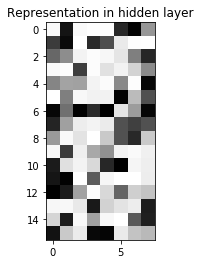

Digit: 5


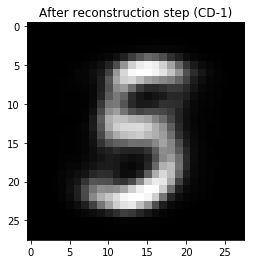

In [120]:
some_plots(5)

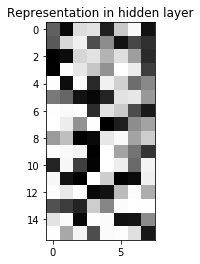

Digit: 4


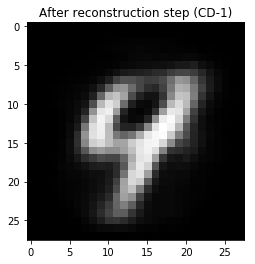

In [122]:
some_plots(4)

In [161]:
def gibbs_sampling(k=10):
    # Start with random initialization of hidden units.
    hidden_sampled = torch.Tensor(np.random.rand(HIDDEN_UNITS))
    print('Predicted label: {}'.format(clf.predict([hidden_sampled.numpy()])[0]))

    # Perform Gibbs Sampling k times.
    for i in range(k):
        visible_sampled = rbm.sample_visible(hidden_sampled)

        # Plotting.
        if i == 0 or i == k-1:
            plt.title('Iteration #{}'.format(i + 1))
            plt.imshow(visible_sampled.numpy().reshape((28,28)), cmap='gray')
            clf.predict(test_features)
            plt.show()

        hidden_sampled = rbm.sample_hidden(visible_sampled)
        
        if i == k-1:
            print('Predicted label: {}'.format(clf.predict([hidden_sampled.numpy()])[0]))

    print('Done!')

Predicted label: 7.0


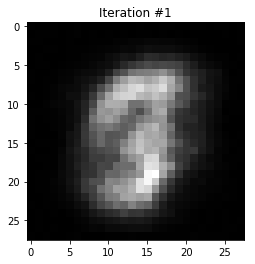

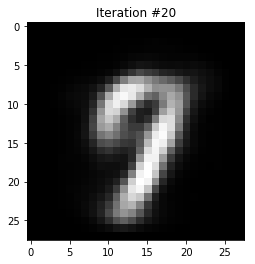

Predicted label: 7.0
Done!


In [168]:
gibbs_sampling(20)

Predicted label: 5.0


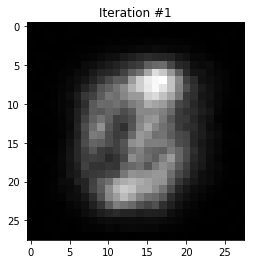

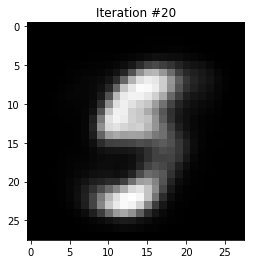

Predicted label: 5.0
Done!


In [163]:
gibbs_sampling(20)